In [98]:
import glob
import os
import oyaml as yaml
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools
import scipy
import uproot
from tqdm.auto import tqdm

plt.style.use('cms')
plt.rcParams.update({
    "figure.dpi": 150,
    "figure.figsize": (4, 3),
    "lines.markersize": 3,
    "errorbar.capsize": 2,
})

## JER stuff

In [99]:
# df = pd.DataFrame()
#nominal_filepath = "output/cpprod/datacard_dphi_jtt_inclusive_zmm_2018.root"
#nominal_filepath = "/vols/build/cms/akd116/newest/dev/CMSSW_8_0_25/src/UserCode/ICHiggsTauTau/Analysis/HiggsTauTau/output/cpprod/datacard__inclusive_zmm_2018.root"
#nominal_filepath = "output/cpprod/tan/datacard_tan_shifted_dphi_jtt_etalow0p0_ptlow30_zmm_2018.root"
#directory = "zmm_inclusive"
# directory = "zmm_shifted_dphi_jtt_eta0.to1.1"
#directory = "zmm_shifted_dphi_jtt_etalow0p0_ptlow30"
#nominal_filepath = "output/cpprod/datacard__shifted_dphi_jtt_etalow0p0_ptlow30.0_zmm_2018.root"
#directories = ["zmm_shifted_dphi_jtt_etalow0p0_ptlow30.0"]

processes = ['data_obs', 'ZTT', 'ZL', 'ZJ', 'TTT', 'TTJ', 'VVT', 'VVJ', 'W', 'QCD', 'EWKZ', 'total_bkg']
path = "/vols/build/cms/akd116/newest/CMSSW_8_0_25/src/UserCode/ICHiggsTauTau/Analysis/HiggsTauTau/"

#datacard = path+"/output/cpprod/datacard_shifted_dphi_jtt_smear_shifted_dphi_jtt_etalow{}_ptlow{}_zmm_2018.root" #smeared
datacard = path+"/output/cpprod/datacard_shifted_dphi_jtt_shifted_dphi_jtt_etalow{}_ptlow{}_zmm_2018.root" #pre-smear
directory = "zmm_shifted_dphi_jtt_etalow{}_ptlow{}"


etas = ["0p0", "1p1", "2p1", "3p0"]

pts = ["30","60"]

dfs = []
for (ptlow, etalow) in [(pt, eta) for pt in pts for eta in etas]:
    print(ptlow, etalow)
    _file = uproot.open(datacard.format(etalow, ptlow))
    #_file = uproot.open(datacard.format(etalow))
    for process in processes:
        hist = _file["{}/{}".format(directory.format(etalow, ptlow), process)]
        # hist = _file["{}/{}".format(directory.format(etalow), process)]
        # print(dir(hist))
        bins = hist.bins
        low_bin_edges = hist.edges
        nbins = hist.numbins
        weights = hist.values
        variance = hist.variances
        
        dfs.append(
            pd.DataFrame({
                "varname0": ["dphi_jtt"] * nbins,
                "binvar0": low_bin_edges[:-1],
                "sum_w": weights,
                "sum_ww": variance,
                "parent": hist.name.decode(),
                "count": hist.values, # not needed
                "pt_low": [ptlow] * nbins,
                "eta_low": [etalow] * nbins,
            })
        )
        
        #df = pd.concat([df, pd.DataFrame({
        #    "varname0": ["dphi_jtt"] * nbins,
        #    "binvar0": low_bin_edges[:-1],
        #    "sum_w": weights,
        #    "sum_ww": variance,
        #    "parent": hist.name.decode(),
        #    "count": hist.values, # not needed
        #    "pt_low": [ptlow] * nbins,
        #    "eta_low": [etalow] * nbins,
        #})], axis='index', sort=False)
df = pd.concat(dfs, axis='index', sort=False).set_index(["parent", "binvar0", "pt_low", "eta_low"])
#df = pd.concat(dfs, axis='index', sort=False).set_index(["parent", "binvar0", "eta_low"])

30 0p0
30 1p1
30 2p1
30 3p0
60 0p0
60 1p1
60 2p1
60 3p0


In [100]:
print(df)

                                    varname0       sum_w      sum_ww  \
parent    binvar0   pt_low eta_low                                     
data_obs  -1.000000 30     0p0      dphi_jtt   64.000000   64.000000   
          -0.975309 30     0p0      dphi_jtt   57.000000   57.000000   
          -0.950617 30     0p0      dphi_jtt   76.000000   76.000000   
          -0.925926 30     0p0      dphi_jtt  100.000000  100.000000   
          -0.901235 30     0p0      dphi_jtt   83.000000   83.000000   
...                                      ...         ...         ...   
total_bkg  0.876543 60     3p0      dphi_jtt    9.816238   11.622926   
           0.901235 60     3p0      dphi_jtt    2.993136    4.077883   
           0.925926 60     3p0      dphi_jtt    3.866831    4.538656   
           0.950617 60     3p0      dphi_jtt    6.255868    8.198813   
           0.975309 60     3p0      dphi_jtt    3.801780    3.983727   

                                         count  
parent    binv

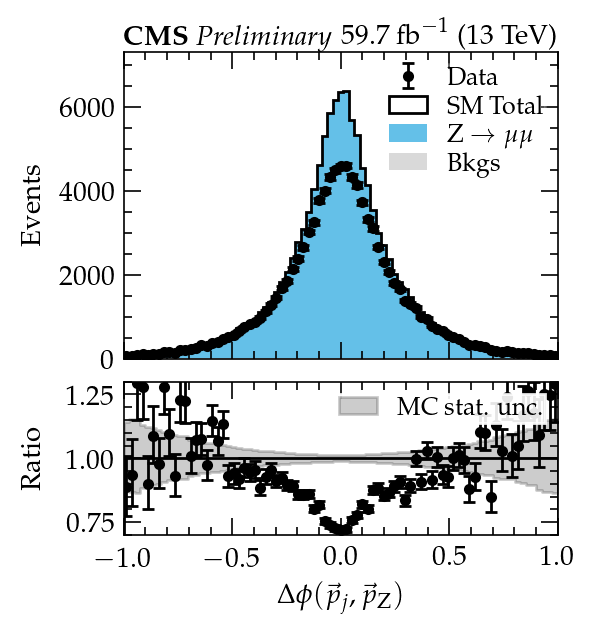

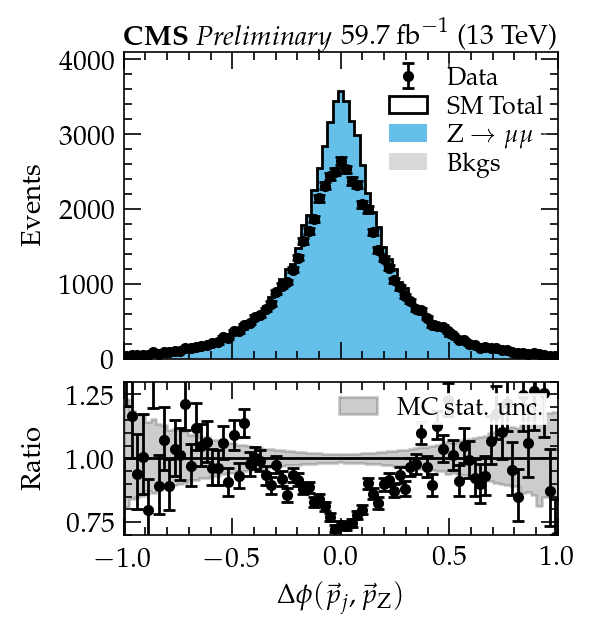

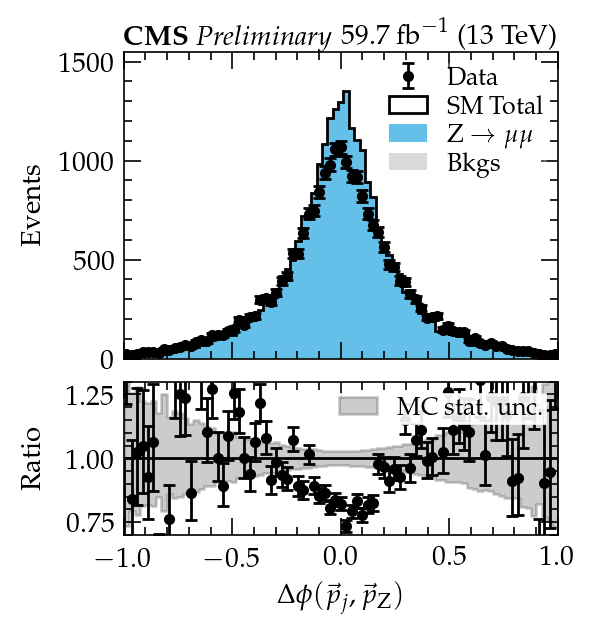

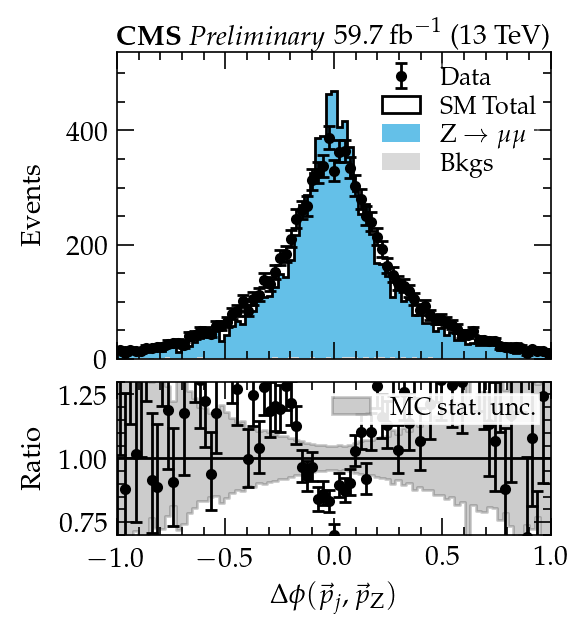

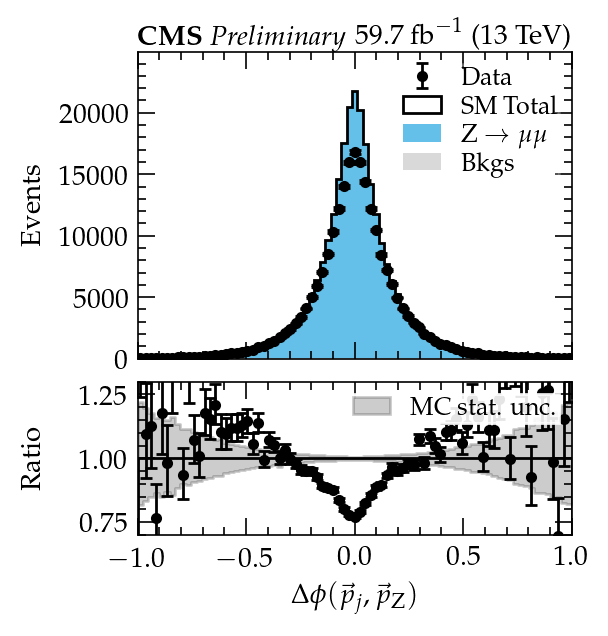

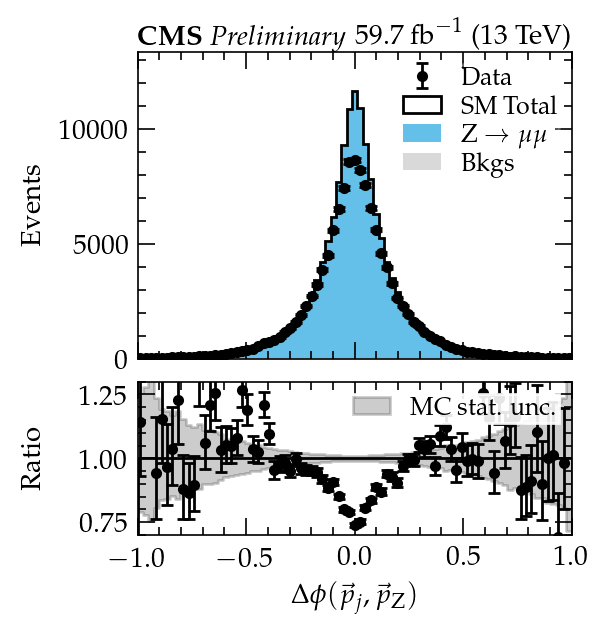

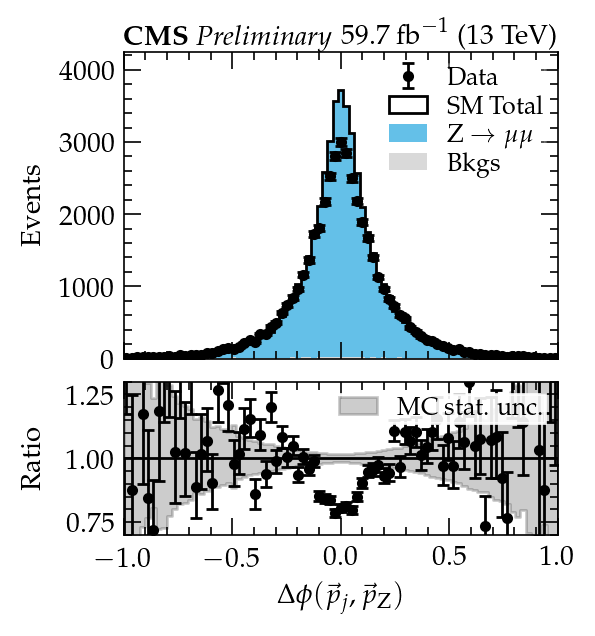

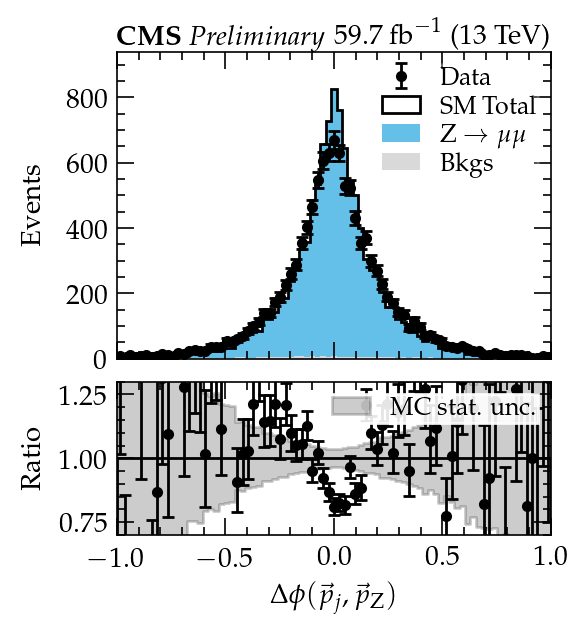

In [101]:
binning = low_bin_edges
#binning = list(filter(lambda x: (x > -1. and x < 1.), binning))

df = dftools.transform.merge(df, {
    "Backgrounds": ["QCD", "TTT", "TTJ", "VVT", "VVJ", "W", "ZTT", "ZJ", "EWKZ"],
    #"ZMM": ["ZL", "ZJ", "EWKZ"],
})


#binning = np.linspace(-1., 1., 41.)

# use this list for later to make fit plots look better
ymaxs = []

data_mask = df.index.get_level_values("parent") != "data_obs"
bkgs_mask = df.index.get_level_values("parent") != "total_bkg"
zl_mask = df.index.get_level_values("parent") != "ZL"

for (ptlow, etalow) in [(pt, eta) for pt in pts for eta in etas]:
    fig, ax = plt.subplots(
        figsize=(2.8, 3.2), dpi=200,
        nrows=2, ncols=1,
        sharex=True, sharey=False,
        gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
    )
    dftools.draw.cms_label(ax[0], "Preliminary", lumi=59.7)
    
    pt_mask = df.index.get_level_values("pt_low") != ptlow
    eta_mask = df.index.get_level_values("eta_low") != etalow
    
    dftools.draw.data_mc(
        ax, df.loc[~data_mask & ~pt_mask & ~eta_mask,:], 
        df.loc[data_mask & bkgs_mask & ~pt_mask & ~eta_mask,:], 
        #ax, df.loc[~data_mask & ~eta_mask,:], 
        #df.loc[data_mask & bkgs_mask & ~eta_mask,:], 
        "binvar0", binning[:-1], log=False, legend=True,
        proc_kw={
            "labels": {
                "SMTotal": "SM Total", 
                "Backgrounds": "Bkgs", 
                "ZL": r'$\mathrm{Z}\rightarrow \mu\mu$'
            },
            "colours": {
                "SMTotal": 'black', 
                "Backgrounds": "#d9d9d9", 
                "ZL": "#64C0E8"},
        },
        legend_kw={'offaxis': False},
    )
    
    ymax = max([
        df.loc[data_mask & bkgs_mask & ~pt_mask & ~eta_mask,:]["sum_w"].max(), 
        df.loc[~data_mask & ~pt_mask & ~eta_mask,:]["sum_w"].max() 
    ])
    ymaxs.append(ymax)
    
    ymax *= 1.15
    
    ax[0].set_ylim(0., ymax)
    ax[1].set_ylim(0.7, 1.3)
    
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(
        handles[::-1], labels[::-1],
        # bbox_to_anchor=(-0.02, 1.02),
        borderpad=0.05, labelspacing=0.1,
        loc=1, fontsize=9, framealpha=0.2,
    )
    ax[1].legend(
        # bbox_to_anchor=(-0.02, 1.02),
        borderpad=0.05, labelspacing=0.1,
        loc=1, fontsize=9, framealpha=0.9,
    )
    
    ax[0].set_ylabel(r'Events')
    ax[1].set_ylabel(r'Ratio')
    ax[1].set_xlabel(r'$\Delta\phi(\vec{p}_{j},\vec{p}_{\mathrm{Z}})$')
    
    fig.align_labels(ax)
    fig.savefig("plots/shifted_dphi_jtt_zmm_2018_etalow{}_ptlow{}.png".format(etalow, ptlow), format='png', bbox_inches='tight')
    #fig.savefig("plots/shifted_dphi_jtt_smeared_zmm_2018_etalow{}_ptlow{}.png".format(etalow, ptlow), format='png', bbox_inches='tight')
    pass

## FIT STUFF

In [121]:
import iminuit
import scipy.signal
import scipy.ndimage

def voigt(x, x0, gamma, sigma):
    z = ((x-x0) + 1j*gamma) / (sigma*np.sqrt(2))
    #z = ((np.tan(x)-x0) + 1j*gamma) / (sigma*np.sqrt(2))
    return np.real(scipy.special.wofz(z))/(sigma*np.sqrt(2*np.pi))

def voigt_tan(x, x0, gamma, sigma):
    #z = ((x-x0) + 1j*gamma) / (sigma*np.sqrt(2))
    z = ((np.tan(x)-x0) + 1j*gamma) / (sigma*np.sqrt(2))
    return np.real(scipy.special.wofz(z))/(sigma*np.sqrt(2*np.pi))

def gauss_linsig(x, x0, sigma_p1, sigma_p0):
    sigma = sigma_p0 + sigma_p1*np.abs(x - x0)
    return scipy.stats.norm.pdf(x, loc=x0, scale=sigma)

def laplace(x, x0, gamma, sigma):
    scale = sigma
    return scipy.stats.laplace.pdf(x, loc=x0, scale=sigma)
    
#def sig_pdf(bins, observable, sig_norm, shape_params):
#    """
#    Currently:
#        return Gaus
#    Change to:
#        return sig_mc (x) ( Gaus (x) Gaus )
#    with inputs:
#        (bins, observable, sig, shape_params)
#    """
#    x0, gamma, sigma = shape_params[:]
#    #sigma = np.sqrt(np.maximum(0., (
#    #    (sigmav - (0.5346/np.sqrt(2*np.log(2)))*gamma)**2
#    #    - (0.2166/(2*np.log(2)))*gamma**2
#    #)))
#    
#    ## approximate integral over bin as bin centre * binwidth
#    ## can use scipy.integrate.quad here to integrate over bins rather than assume straight line
#    #shape = voigt(observable, x0, gamma, sigma) * (bins[1]-bins[0])
#    #shape = np.trapz(voigt(observable, x0, gamma, sigma), dx=0.001)
#    gs = []
#    # for _bin in bins:
#    #     gs.append(laplace(_bin, x0, gamma, sigma))
#    # shape = np.trapz(gs, dx=0.001, axis=0)
#    shape = gauss_linsig(observable, x0, gamma, sigma) * (bins[1]-bins[0])
#    return sig_norm * shape / shape.sum()

def sig_pdf(bins, observable, sig, shape_params):
    """
    Currently:
        return Gaus
    Change to:
        return sig_mc (x) ( Gaus (x) Gaus )
    with inputs:
        (bins, observable, sig, shape_params)
    """
    #rsig, _, x0, sigma_l0, sigma_l1, sigma_r0, sigma_r1 = shape_params[:]
    rsig, _, x0, sigma_l1, sigma_l0, sigma_r1, sigma_r0 = shape_params[:]
    #shape = gauss_linsig(observable, x0, sigma_1, sigma_0) * (bins[1]-bins[0])
    gauss_func = gauss_linsig(observable, x0, sigma_l1, sigma_l0)
    shape_l = (gauss_func / gauss_func.sum()) * (bins[1]-bins[0])
    #shape_r = gauss_linsig(observable, -x0, sigma_l1, sigma_l0) * (bins[1]-bins[0])
    #conv_0 = scipy.signal.fftconvolve(shape_l, shape_r, mode='same')
    #conv_1 = scipy.signal.fftconvolve(sig, conv_0, mode='same')
    #conv = scipy.signal.fftconvolve(sig, shape_l, mode='same')
    #shape_l = np.trapz(gauss_linsig(observable, x0, sigma_l1, sigma_l0) * (bins[1]-bins[0]))
    conv = scipy.ndimage.filters.convolve(sig, shape_l)
    return rsig * sig.sum() * conv / conv.sum()
    #return rsig * sig.sum() * shape_l / shape_l.sum()

def bkg_pdf(bkg, bkg_norm):
    return bkg_norm * bkg / bkg.sum()

def pred_pdf(bins, observable, sig, shape_params, bkg, bkg_norm):
    return sig_pdf(bins, observable, sig, shape_params) + bkg_pdf(bkg, bkg_norm*shape_params[1])

def nll(bins, observable, data, sig, bkg, bkg_neff, params, sat=False):
    sig_norm = sig.sum()
    bkg_norm = bkg.sum()
    
    shape_params = params[:7]
    mcstat_params = np.array(params[7:])
    
    # only constrain background mc stat when background exists in that bin
    pred = pred_pdf(bins, observable, sig, shape_params, mcstat_params, bkg_norm)
    if sat:
        pred = data
    pois_pdf = np.sum(scipy.stats.poisson.logpmf(data, pred))
    
    scale = np.ones_like(bkg)
    mask = (bkg>1e-10) & (bkg_neff>1e-10)
    scale[mask] = (bkg/bkg_neff)[mask]
    bkg[~mask] = 0.
    bkg_neff[~mask] = 0.
    
    nuis_pdf = np.sum(scipy.stats.gamma.logpdf(mcstat_params, bkg_neff+1, scale=scale))
    return -2*(pois_pdf + nuis_pdf)

def gen_data(bins, observable, sig, bkg, bkg_neff, params, seed=123456):
    np.random.seed(seed)
    sig_norm = sig.sum()
    bkg_norm = bkg.sum()
    
    sig_scale, bkg_scale = params[:2]
    shape_params = params[2:7]
    mcstat_params = np.array(params[7:])
    
    pred = pred_pdf(bins, observable, sig, sig_scale, shape_params, mcstat_params, bkg_norm, bkg_scale)
    return scipy.stats.poisson.rvs(pred)

### Data Fits

In [117]:
import numdifftools

class LogLHData(object):
    def __init__(self, fnll, fsig, fbkg, fgen):
        self._fnll = fnll
        self._data_set = False
        
        self._fsig = fsig
        self._fbkg = fbkg
        self._fgen = fgen
        
    def set_data(self, bins, dfdata, dfsig, dfbkg, fcn="voigt"):
        self._dfdata = dfdata
        self._dfsig = dfsig
        self._dfbkg = dfbkg
        
        self._data_set = True
        self._bins = bins
        self._obs = (bins[1]+bins[0])/2.
        self._data = dfdata["sum_w"].values
        self._bkg = np.maximum(0., dfbkg["sum_w"].values)
        self._bkg_neff = dfbkg.eval("sum_w**2/sum_ww").values
        self._sig = np.maximum(0., dfsig["sum_w"].values)
        self._sig_neff = dfsig.eval("sum_w**2/sum_ww").values
        
        if fcn == "voigt":
            self._params = ["rsig", "rbkg", "x0", "sigma_l1", "sigma_l0", "sigma_r1", "sigma_r0"]
            self._params.extend([f'bneff{idx}' for idx in range(bins[0].shape[0])])
            
            x0_prefit = (self._data*self._obs).sum()/self._data.sum()
            #x0_prefit = 0.
            self._init_params = [1., 1., x0_prefit, 1., 1., 0., 0.]
            self._init_params.extend(self._bkg)
            self._init_params = np.array(self._init_params)
        
            self._lim_params = [(0., 5e6), (0., 5), (-0.5, 0.5), (0., 1.), (0., 1.), (0., 1.), (0., 1.)]
            self._lim_params.extend([(0, None) for idx in range(bins[0].shape[0])])
        
            self._fix_params = [False, True, False, False, False, True, True]
            self._fix_params.extend([True for idx in range(bins[0].shape[0])])
        elif fcn == "gauss":
            self._params = ["rsig", "rbkg", "x0", "sigma0", "sigma1"]
            self._params.extend([f'bneff{idx}' for idx in range(bins[0].shape[0])])
            
            x0_prefit = (self._data*self._obs).sum()/self._data.sum()
            self._init_params = [1., 1., x0_prefit, 0., 20.]
            self._init_params.extend(self._bkg)
            self._init_params = np.array(self._init_params)
        
            self._lim_params = [(0.5, 2), (0.5, 2), (-100, 100), (0, 100), (0, 100)]
            self._lim_params.extend([(0, None) for idx in range(bins[0].shape[0])])
        
            self._fix_params = [False, True, False, True, False]
            self._fix_params.extend([False for idx in range(bins[0].shape[0])])
            
        
    def __call__(self, params, saturated=False):
        self._params_vals = params
        return self.evaluate(saturated=saturated)
        
    def evaluate(self, saturated=False):
        if not self._data_set:
            raise RuntimeError("Data is not set for LogLH")
        return self._fnll(self._bins, self._obs, self._data, self._sig, self._bkg, self._bkg_neff, self._params_vals, sat=saturated)
    
    def get_minuit_args(self):
        return (self._init_params,)
        
    def get_minuit_kwargs(self):
        return {
            "name": self._params,
            "fix": self._fix_params,
            "limit": self._lim_params,
        }
    
    def create_minuit(self, **kwargs):
        _kwargs = copy.deepcopy(self.get_minuit_kwargs())
        _kwargs.update({"errordef": 1, "pedantic": False})
        _kwargs.update(kwargs)
        return iminuit.Minuit.from_array_func(
            self, *self.get_minuit_args(), **_kwargs,
        )
    
    def sig_pdf(self, params, rebin=None):
        #sig_norm = self._sig.sum()*params[0]
        sig = self._fsig(self._bins, self._obs, self._sig, params[:7])
        
        if rebin is not None:
            sig_rebin = self._fsig(rebin, (rebin[:-1]+rebin[1:])/2., self._sig, params[:7])
            return sig_rebin*float(rebin.shape[0])#/float(self._bins[0].shape[0])
        return sig
    
    def sig_pdf_ci(self, params, covariance, rebin=None):
        jac = numdifftools.Jacobian(lambda x: self.sig_pdf(x, rebin=rebin))(params)
        return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def bkg_pdf(self, params):
        bkg_norm = self._bkg.sum()*params[1]
        return self._fbkg(params[7:], bkg_norm)
    
    def bkg_pdf_ci(self, params, covariance):
        jac = numdifftools.Jacobian(self.bkg_pdf)(params)
        return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def pred_pdf(self, params):
        return self.sig_pdf(params) + self.bkg_pdf(params)
    
    def pred_pdf_ci(self, params, covariance):
        return [0.]*self.pred_pdf.shape[0]
        #jac = numdifftools.Jacobian(self.pred_pdf)(params)
        #return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def gen_toy(self, params, seed=123456):
        return self._fgen(self._bins, self._obs, self._sig, self._bkg, self._bkg_neff, params, seed=seed)

In [118]:
def draw_data_fit_results(ax, model, minimizer, legend_kw={}, log=True):
    bin_low, bin_high = model._bins
    bins = np.array(list(bin_low) + [bin_high[-1]])
    obs = model._obs
    data = model._data

    fine_bins = np.linspace(bin_low.min(), bin_high.max(), bin_low.shape[0]*10+1)
    signal = model.sig_pdf(minimizer.np_values()) #, rebin=fine_bins)
    background = model.bkg_pdf(minimizer.np_values())
    prediction = model.pred_pdf(minimizer.np_values())

    ax[0].set_xlim(bin_low.min(), bin_high.max())
    if log:
        ax[0].set_yscale('log')
    #ax[0].set_ylabel('Events')
    #dftools.draw.cms_label(ax[0], '')
    
    # Data points
    errlow, errhigh = dftools.stats.poisson_interval(data)
    ax[0].errorbar(
        obs, data, yerr=((data-errlow), (errhigh-data)),
        fmt='o', color='black', lw=1, label='Data',
        alpha=0.5
    )
    
    # Fit prediction
    ax[0].hist(
        obs, bins=bins, weights=prediction,
        histtype='step', color='#1f78b4', label='Fit',
    )
    #sigma = model.pred_pdf_ci(minimizer.np_values(), minimizer.np_matrix(skip_fixed=False))
    #ax[0].fill_between(
    #    bins, list(prediction+sigma)+[(prediction+sigma)[-1]],
    #    list(prediction-sigma)+[(prediction-sigma)[-1]],
    #    step='post', color='#1f78b4', alpha=0.3,
    #)
    
    # Signal
    #ax[0].hist(
    #    obs, bins=bins, weights=signal,
    #    color='#ff7f00', lw=1, label='Sig.',
    #    histtype='step',
    #)
    #ax[0].plot(
    #    (fine_bins[1:]+fine_bins[:-1])/2, signal/40.,
    #    '-', color='#ff7f00', lw=1, label='Sig.',
    #)
    
    # Signal prefit x rsig (bestfit)
    sig_prefit = model._sig
    ax[0].hist(
        obs, bins=bins, weights=sig_prefit * minimizer.values[0],
        color='#ff7f00', lw=1, label='Sig.',
        histtype='step',
    )
    
    # Background
    ax[0].hist(
        obs, bins=bins, weights=background,
        color='#e31a1c', label='Bkg.',
        alpha=0.5,
    )
    
    # Background prefit
    bkg_prefit = model._bkg
    ax[0].hist(
        obs, bins=bins, weights=bkg_prefit,
        color='#e31a1c', histtype='step',
        ls='--', label='Bkg. prefit',
    )
    
    # Conv function
    #conv_func = gauss_linsig(obs, minimizer.values[2], minimizer.values[3], minimizer.values[4])
    #convolution = scipy.ndimage.filters.convolve(sig_prefit, conv_func)
    #convolution *= sig_prefit.sum()/convolution.sum() * minimizer.values[0]
    #ax[0].hist(
    #    obs, bins=bins, 
    #    weights=conv_func ,
    #    color='#FACAFF', label='Smear',
    #    #histtype='step',
    #    alpha=0.5,
    #)
    
    #handles, labels = ax[0].get_legend_handles_labels()
    #kwargs = {"loc": 2, "labelspacing": 0.2}
    #kwargs.update(legend_kw)
    #ax[0].legend(
    #    handles[::-1], labels[::-1],
    #    **kwargs,
    #)
    
    # lower panel
    #ax[1].set_ylabel("Data/Pred. - 1")
    
    # Ratio data
    ax[1].errorbar(
        obs, (data/prediction-1), yerr=(((data-errlow)/prediction), ((errhigh-data)/prediction)),
        fmt='o', color='black', lw=1,
    )
    
    # Ratio pred
    ax[1].hist(
        obs, bins=bins, weights=np.zeros_like(prediction),
        histtype='step', color='#1f78b4',
    )
    #up = sigma/prediction
    #do = -sigma/prediction
    #ax[1].fill_between(
    #    bins, list(up)+[up[-1]], list(do)+[do[-1]],
    #    step='post', color='#1f78b4', alpha=0.3,
    #)

In [119]:
def perform_data_fit(model, binning, df_data, df_sig, df_bkg, idx=0, fcn="voigt"):
    
    model.set_data(
        (binning[:-1], binning[1:]),
        df_data, df_sig, df_bkg,
        fcn="voigt",
    )
    minimizer = model.create_minuit()
    #minimizer.migrad()
    #minimizer.minos()
    return model, minimizer

/home/hep/akd116/miniconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/home/hep/akd116/miniconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


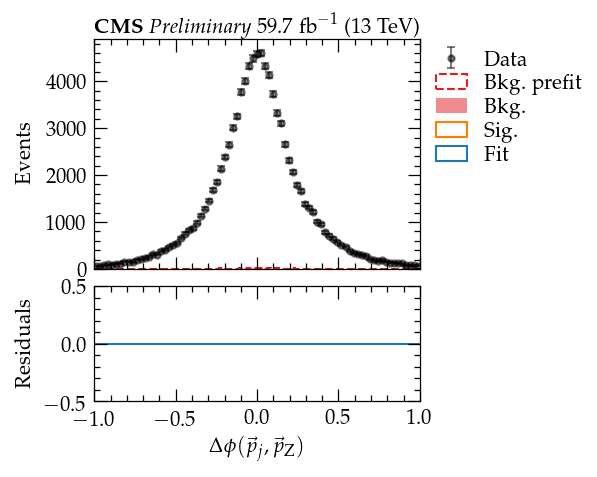

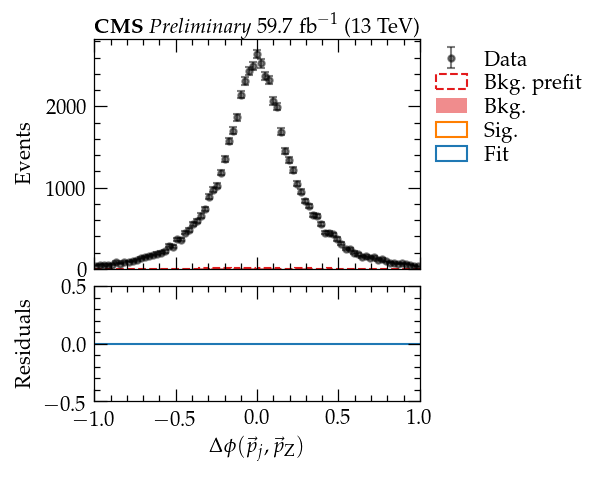

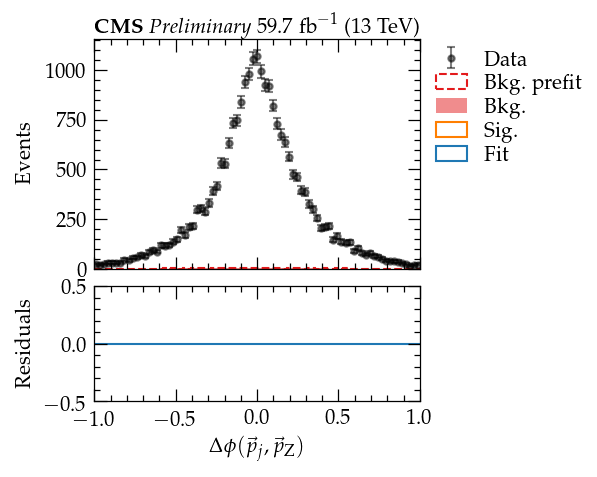

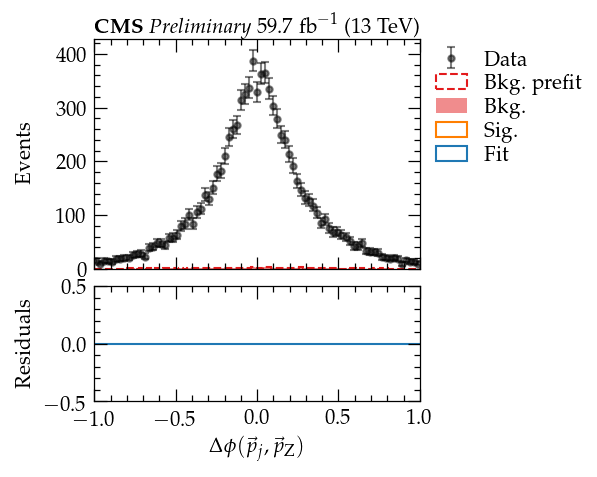

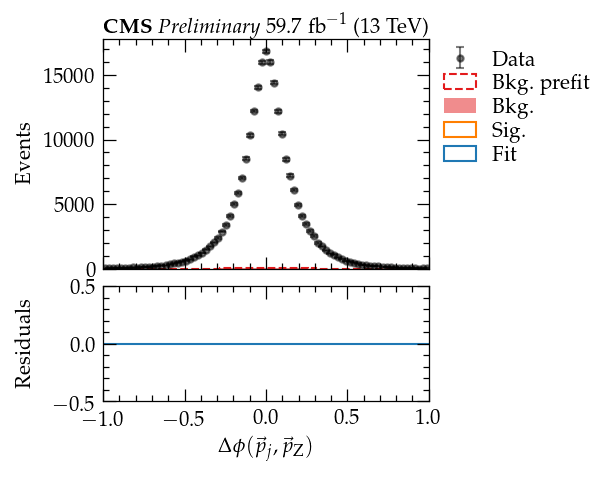

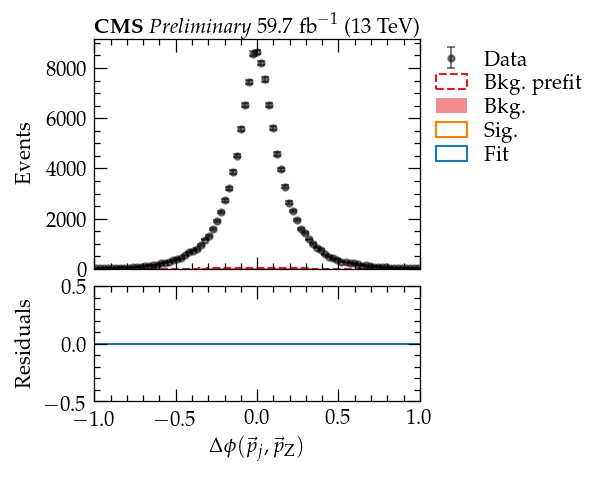

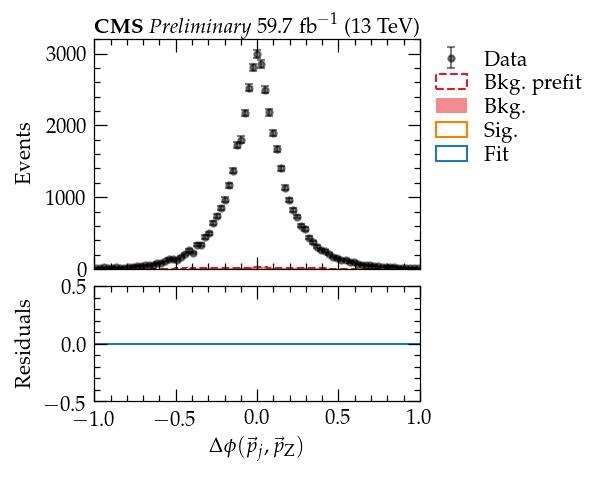

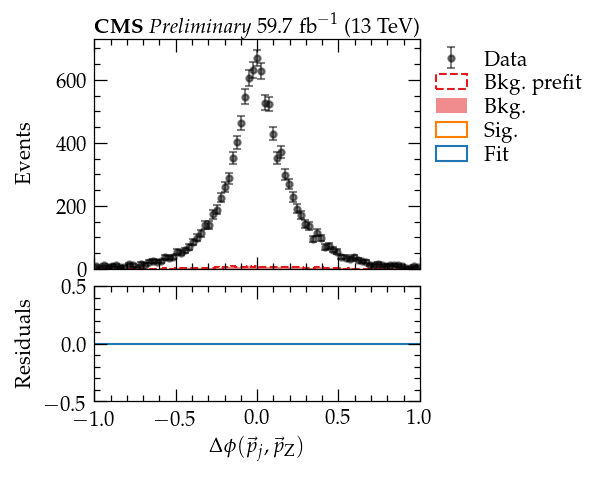

In [120]:
model = LogLHData(nll, sig_pdf, bkg_pdf, gen_data)
#df_data_region = df_data.loc[("central", "ZCand_pt", "METnoX_ptParaZCandCent", "DoubleMuon", "MET"),:].groupby(["binvar0", "binvar1"]).sum()
#df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptParaZCandCent", "DoubleMuon"),:].groupby(["parent", "binvar0", "binvar1"]).sum()
#
#binning = np.arange(-210.,  201., 10.)
minis = []
for bin_idx, (ptlow, etalow) in enumerate([(pt, eta) for pt in pts for eta in etas]):
    pt_mask = df.index.get_level_values("pt_low") != ptlow
    eta_mask = df.index.get_level_values("eta_low") != etalow
    
    #df_data_region = dftools.transform.rebin(df.loc[~data_mask & ~pt_mask & ~eta_mask,:], binning[:-1])
    #df_mc_region = dftools.transform.rebin(df.loc[data_mask & bkgs_mask & zl_mask & ~pt_mask & ~eta_mask,:], binning[:-1])
    df_data_region = dftools.transform.rebin(df.loc[~data_mask & ~pt_mask & ~eta_mask,:], binning[:-1])
    df_sig_region = dftools.transform.rebin(df.loc[~zl_mask & ~pt_mask & ~eta_mask,:], binning[:-1])
    df_bkg_region = dftools.transform.rebin(df.loc[data_mask & bkgs_mask & zl_mask & ~pt_mask & ~eta_mask,:], binning[:-1])
    
    idx = 4
    mod_data, mini_data = perform_data_fit(model, binning, df_data_region, df_sig_region, df_bkg_region, idx=idx)
    mini_data.migrad(ncall=1e7)
    minis.append(mini_data)
    

    fig, ax = plt.subplots(
        figsize=(2.8, 3.2), dpi=150,
        nrows=2, ncols=1,
        sharex=True, sharey=False,
        gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
    )
    
    draw_data_fit_results(ax, mod_data, mini_data, log=False)
    #ax[0].set_xlim(-200., 200.)
    #ax[0].set_ylim(0.3, 1e3)
    ax[1].set_ylim(-0.5, 0.5)
    
    dftools.draw.cms_label(ax[0], "Preliminary", lumi=59.7)
    
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(
        handles[::-1], labels[::-1],
        bbox_to_anchor=(1.01, 1.01),
        labelspacing=0.1,
        ncol=1,
        borderpad=0.1, frameon=False,
    )
    #ax[0].set_xlim(-1., 1.)
    #ax[0].set_ylim(0., 100.)
    #ax[0].set_ylim(0., ymaxs[bin_idx]*1.05)
    ax[0].set_ylabel(r'Events')
    ax[1].set_ylabel(r'Residuals')
    ax[1].set_xlabel(r'$\Delta\phi(\vec{p}_{j},\vec{p}_{\mathrm{Z}})$')
    fig.align_labels()
    
    fig.savefig("plots/resolution_fits_ptlow{}_etalow{}.png".format(ptlow, etalow), format='png', bbox_inches='tight')
    pass

/home/hep/akd116/miniconda2/envs/shane/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


[30.002734036229583, 24.451053161589243, 19.482958183082815, 15.092511496024485, 11.27386581383547, 8.021262193756513, 5.329028263984014, 3.1915764971172393, 1.6034025263438139, 0.559083503270756, 0.05327649604697626, 0.0807169266533947, 0.6362170462233507, 1.7146644472534263, 3.311020611652907, 5.420319493623026, 8.037666136306598, 11.158235321383245, 14.777270250436175, 18.890081257497513, 23.492044551581216]


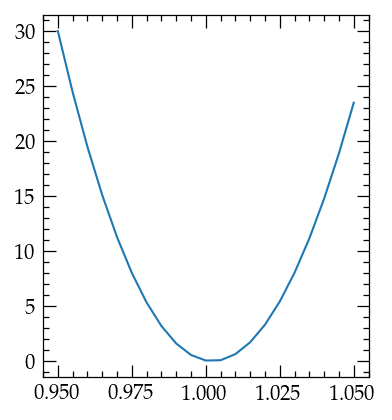

In [23]:
xs = np.linspace(0.95, 1.05, 21)
ys = []
mini_data.fixed['rsig'] = False
bf_min_data = mini_data.migrad().fmin.fval
mini_data.minos()

for x in xs:
    mini_data.fixed['rsig'] = True
    mini_data.values['rsig'] = x
    try:
        result = mini_data.migrad()
        ys.append(result.fmin.fval - bf_min_data)
    except RuntimeError:
        ys.append(np.nan)
            
print(ys)
fig, ax = plt.subplots(figsize=(2.8, 3.2), dpi=150,)
ax.plot(xs, ys)

### Write out fit result into TF1

In [75]:
import ROOT

In [76]:
#func = 'TMath::Gaus(x, mean, (sigma_0+sigma_1*fabs(x-mean)))' # this one doesn't work with scale(x)
#func = '1/(sqrt(2*pi*(sigma_0+sigma_1*fabs(x))^(2))) * (exp(-x^(2)/(2*(sigma_0+sigma_1*fabs(x))^(2))))'
func = '1/(sqrt(2*pi*(sigma_0+sigma_1*fabs(x-mean))^(2))) * (exp(-x^(2)/(2*(sigma_0+sigma_1*fabs(x-mean))^(2))))'
func_file = ROOT.TFile("smear_file_2018_zmm_formula_locnotfixed.root", "RECREATE")
func_name = "smear_func_ptlow{}_etalow{}"
pteta_bins = [(pt, eta) for pt in pts for eta in etas]
                       
for index, mini in enumerate(minis):
    mean = mini.values[2] # be careful with including mean
    sigma_l0 = mini.values[4]
    sigma_l1 = mini.values[3]
    name = func_name.format(pteta_bins[index][0], pteta_bins[index][1])
    print(name)
    new_func = func.replace("mean", str(mean)).replace("sigma_0", str(sigma_l0)).replace("sigma_1", str(sigma_l1))
    #new_func = func.replace("sigma_0", str(sigma_l0)).replace("sigma_1", str(sigma_l1))
    print(new_func)
    # then make this into TF1 between -1 < x < 1
    function = ROOT.TF1(name, new_func, -1., 1.)
    function.Write()
func_file.Close()

smear_func_ptlow30_etalow0p0
1/(sqrt(2*pi*(0.03317867490490445+0.273446341046542*fabs(x--7.274919663158297e-05))^(2))) * (exp(-x^(2)/(2*(0.03317867490490445+0.273446341046542*fabs(x--7.274919663158297e-05))^(2))))
smear_func_ptlow30_etalow1p1
1/(sqrt(2*pi*(0.08179532639663728+0.041637905977642276*fabs(x--0.00036933530339677834))^(2))) * (exp(-x^(2)/(2*(0.08179532639663728+0.041637905977642276*fabs(x--0.00036933530339677834))^(2))))
smear_func_ptlow30_etalow2p1
1/(sqrt(2*pi*(0.00018105242703952973+0.7544487475600077*fabs(x--0.0007069081993955617))^(2))) * (exp(-x^(2)/(2*(0.00018105242703952973+0.7544487475600077*fabs(x--0.0007069081993955617))^(2))))
smear_func_ptlow30_etalow3p0
1/(sqrt(2*pi*(0.06807970699831956+0.2233232430822235*fabs(x-0.0014305923074082738))^(2))) * (exp(-x^(2)/(2*(0.06807970699831956+0.2233232430822235*fabs(x-0.0014305923074082738))^(2))))
smear_func_ptlow60_etalow0p0
1/(sqrt(2*pi*(0.021771196304387064+0.2669685437253657*fabs(x-0.0015059951784659464))^(2))) * (exp(-

### Plot gauss function

In [11]:
bin_centres = (binning[1:] + binning[:-1])/2
conv_func = gauss_linsig(bin_centres, minis[0].values[2], minis[0].values[3], minis[0].values[4])
plt.plot(bin_centres, conv_func/12)

NameError: name 'minis' is not defined

### Testing things

In [67]:
for jid in ["A", "B", "C", "D",]:
    print(jid)
    bla = uproot.open(f"/vols/cms/mhh18/Offline/output/SM/11Nov_Run2018_tautau_inclSyst/Tau{jid}_tt_2018.root")["ntuple"]
    bla = uproot.open(f"/vols/cms/adow/Offline/output/SM/2020/Mar02_2017/{jid}_tt_2018.root")["ntuple"]

    #dy = bla.pandas.df(["dphi_jtt", "smear_jet_delta", "jeta_1", "m_vis", "pt_tt", "n_jets", "jpt_1", "wt"], namedecode="utf-8")
    dy = bla.pandas.df(["event","run","lumi","wt"], namedecode="utf-8")
    
    display(dy.shape)
    display(dy.drop_duplicates(inplace=True).shape)

A


(3420108, 4)

AttributeError: 'NoneType' object has no attribute 'shape'

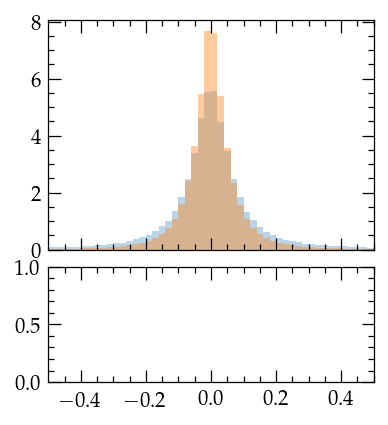

In [149]:
fig, ax = plt.subplots(
    figsize=(2.8, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
)
binning = np.linspace(-0.5, 0.5, 51)
bin_centre = (binning[:-1] + binning[1:])/2

mask = dy.eval("n_jets==1 and 30<jpt_1<60 and abs(jeta_1)<1.1")

conv_func = gauss_linsig(bin_centre, minis[0].values[2], minis[0].values[3], minis[0].values[4])
conv_func *= 1/conv_func.sum()

ax[0].hist(dy.loc[mask, "smear_jet_delta"], binning, weights=dy.loc[mask, "wt"], alpha=0.3, density=True)
ax[0].hist(bin_centre, binning, weights=conv_func, alpha=0.4, density=True)
ax[0].set_xlim(-.5,.5)
pass
#ax[0].hist2d(dy["jeta_1"], dy["shifted_dphi_jtt"],binning, weights=dy["wt"])
#fig.colorbar()

In [6]:
np.random.seed(1234)

In [ ]:
minis[0].values[4] + minis[0].values[3]*np.abs(x - x0)

In [ ]:
gauss_pdf = gauss_linsig(observable, x0, sigma_l1, sigma_l0)

scipy.stats.norm.rvs(loc=minis[0].values[2], scale=)

In [5]:
df

varname0       sum_w      sum_ww  \
parent    binvar0   pt_low eta_low                                     
data_obs  -1.000000 30     0p0      dphi_jtt  121.000000  121.000000   
          -0.951220 30     0p0      dphi_jtt  166.000000  166.000000   
          -0.902439 30     0p0      dphi_jtt  189.000000  189.000000   
          -0.853659 30     0p0      dphi_jtt  248.000000  248.000000   
          -0.804878 30     0p0      dphi_jtt  291.000000  291.000000   
...                                      ...         ...         ...   
total_bkg  0.756098 60     3p0      dphi_jtt   18.467683   20.609750   
           0.804878 60     3p0      dphi_jtt   13.977226   15.837216   
           0.853659 60     3p0      dphi_jtt   16.322445   18.457651   
           0.902439 60     3p0      dphi_jtt    8.120801   10.207317   
           0.951220 60     3p0      dphi_jtt    8.796387   10.591762   

                                         count  
parent    binvar0   pt_low eta_low              
data_obs  -1.000000 30     0p0      121.000000  
          -0.951220 30     0p0      166.000000  
          -0.902439 30     0p0      189.000000  
          -0.853659 30     0p0      248.000000  
          -0.804878 30     0p0      291.000000  
...                                        ...  
total_bkg  0.756098 60     3p0       18.467683  
           0.804878 60     3p0       13.977226  
           0.853659 60     3p0       16.322445  
           0.902439 60     3p0        8.120801  
           0.951220 60     3p0        8.796387  

[3936 rows x 4 columns]